## Import Libraries

In [26]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
import operator
from sklearn.metrics import balanced_accuracy_score
from sklearn import svm
import impyute as impy
from xgboost import XGBClassifier
from xgboost import plot_tree
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import shap
from mlxtend.evaluate import bootstrap
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import format_float_scientific
import inspect
from imblearn.ensemble import BalancedRandomForestClassifier
import datetime

## Load Data

In [27]:
df = pd.read_sas('hapi_dataset.sas7bdat')

## Predictor Coding and Selection

In [28]:
# coding
df.loc[df['bmiadmission'] < 18.5, 'bmitri'] = -1
df.loc[(df['bmiadmission'] >= 18.5) & (df['bmiadmission'] < 35), 'bmitri'] = 0
df.loc[df['bmiadmission'] >= 35, 'bmitri'] = 1
df.loc[:,'wgtchgcat'] = df.loc[:,'wgtchgcat'].map({b'lost > 2 lbs':-1,b'< 2 lb change':0,b'gained > 2 lbs':1})

# punpoa is target of interest
m3 = ['punpoa', 'ageatarrival', 'male',  'white', 'hxsmoke', 'bmitri', 'admit_icu', 
      'ambulate', 'bedrest', 'npo', 'timeinor', 'malnut', 'charlsonscore','avgmois', 
      'avgsensperc', 'avgact', 'avgmob', 'avgnut', 'avgfric',
      'lowmois', 'lowsensperc', 'lowact', 'lowmob', 'lownut', 'lowfric']
df = df[m3]

## Plot Missingness

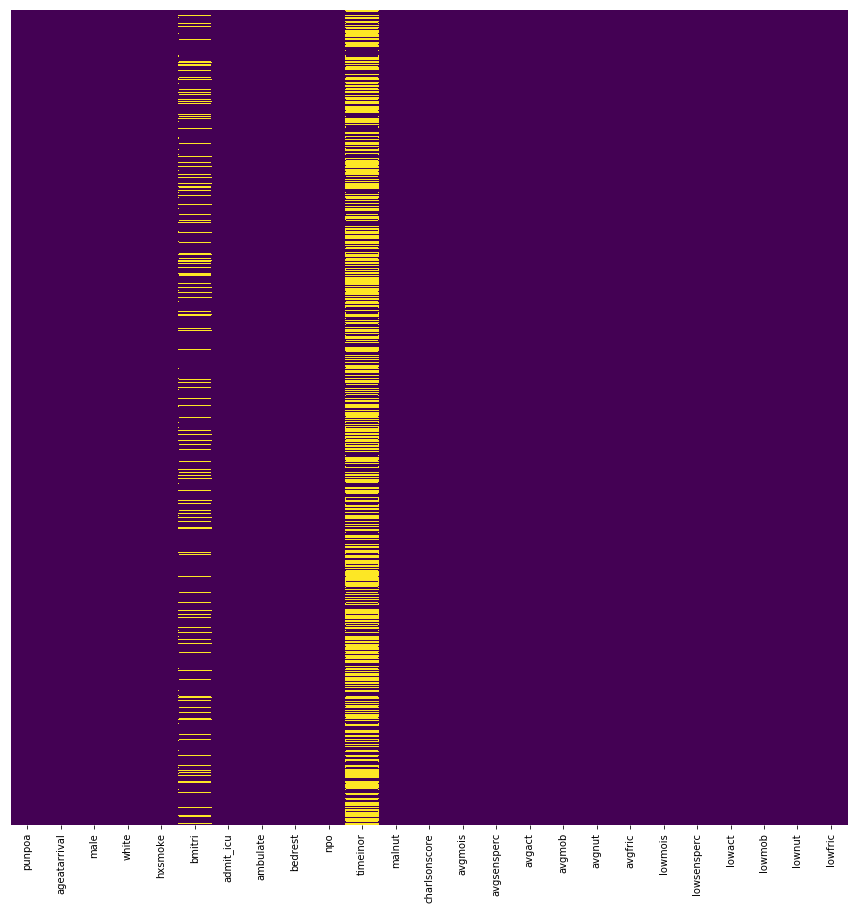

In [9]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Split Data into Training/Validation

In [32]:
X,y = df.drop(columns=['punpoa']),df['punpoa']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify=y.values, random_state=42)


## Imputation

In [34]:
imputer=IterativeImputer(sample_posterior=True).fit(X_train.values)
X_train.iloc[:,:] = imputer.transform(X_train.values) 
X_test.iloc[:,:] = imputer.transform(X_test.values)

# Main Functions
- Grid search (did bulk of search in other repositories and added ideal search parameters here)  
- SHAP  
- Bootstrapped AUC 
- Sensitivity Analysis  
- Additional plotting of ROC and SHAP per patient

In [35]:
def perform_grid_search(estimator, options, param_grid, no_grid, X_train, X_test, y_train, y_test, return_probs=True):
    if 'random_state' in list(inspect.getargspec(estimator))[0]:
        options['random_state']=42
    if not no_grid:
        grid_search = GridSearchCV(estimator=estimator(**options), param_grid=param_grid, scoring='roc_auc', cv=5, verbose=False)
        grid_search.fit(X_train,y_train)
        best_params=grid_search.best_params_
    else:
        best_params=options
    options.update(best_params)
    best_estimator=estimator(**options)
    best_estimator.fit(X_train,y_train)
    y_pred=best_estimator.predict(X_test)
    if 'predict_proba' in dir(best_estimator) and return_probs:
        y_pred_probs=best_estimator.predict_proba(X_test)[:,1]
    else:
        y_pred_probs = y_pred
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs, drop_intermediate=False)
    roc_df = pd.DataFrame(np.vstack([fpr,tpr,thresholds]).T,columns=['1-Specificity','Sensitivity','Thresholds'])
    results=pd.DataFrame(np.vstack([y_test.values,y_pred,y_pred_probs]).T,columns=['y_true','y_pred','y_pred_probs'])
    return best_estimator, roc_df, results
    
def run_shap(X_train, X_test, best_estimator, model_type='tree', explainer_options={}, get_shap_values_options={}, overall=False):
    
    shap.initjs()
    
    shap_model={'tree':shap.TreeExplainer,'kernel':shap.KernelExplainer,'linear':shap.LinearExplainer}[model_type]

    explainer = shap_model(best_estimator, X_train,**explainer_options)

    shap_values = explainer.shap_values(X_test,**get_shap_values_options)
    
    if model_type=='tree' and best_estimator.__class__.__name__!='XGBClassifier':
        shap_values=np.array(shap_values)[1,...]

    shap.summary_plot(shap_values, X_test,feature_names=list(X_train), plot_type='bar' if overall else 'dot', max_display=30)
    
    return explainer, shap_values
    
def extract_ys(Y):
    return Y[:,0], Y[:,1]

def auc(Y):
    y_true, y_pred=extract_ys(Y)
    return roc_auc_score(y_true, y_pred)

def return_bootstrap_results(results,fn,round_place=1):
    Y=results[['y_true','y_pred_probs']].values
    original, std_err, ci_bounds = bootstrap(Y, num_rounds=1000,
                                             func=fn,
                                             ci=0.95,
                                             seed=123)
    std_err=format_float_scientific(std_err,round_place)
    if float(std_err) >= 0.001:
        std_err=float(std_err)
    
    return "{}±{}".format(float(format_float_scientific(original,round_place)),2*std_err)
    
def plot_roc(roc_df, results):
    plt.figure()
    ax=sns.lineplot('1-Specificity','Sensitivity',data=roc_df)
    plt.title("AUC: {}".format(return_bootstrap_results(results,auc,2)))#roc_auc_score(results['y_true'], results['y_pred_probs']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    
def get_nearest(arr,vals=np.arange(0.1,1.,0.1)):
    idx=[]
    for val in vals:
        idx.append(np.argmin(np.abs(arr-val)))
    return np.array(idx)
    
def sensitivity_analysis(roc_df, intervals=0.1):
    df=roc_df.iloc[get_nearest(roc_df['Thresholds'].values,np.arange(intervals,1.,intervals))]
    df['Specificity']=1.-df['1-Specificity']
    df=round(df[['Sensitivity','Specificity','Thresholds']].reset_index(drop=True),2)
    return df
    
def shap_patient(i, explainer, shap_values, logistic=True, tree=False):
    opts={}
    expected=explainer.expected_value
    if logistic:
        opts=dict(link='logit')  
    if tree:
        expected=explainer.expected_value[1]
    shap.force_plot(expected, shap_values[i, :], X_test.values[i, :], feature_names=list(X_test), matplotlib=True, show=True, **opts)
    
def plot_rocs(roc_dict):
    for k in roc_dict:
        roc_dict[k]['Method']=k
    df=pd.concat(list(roc_dict.values()))
    plt.rcParams['figure.dpi']=300
    plt.figure(figsize=(10,10))
    plt.plot([0,1],[0,1],'--')
    sns.lineplot('1-Specificity','Sensitivity',hue='Method',data=df)

## Return Estimators  
- Logistic Regression  
- Naive Bayes  
- Decision Trees  
- Random Forest  
- XGBoost  

In [37]:
# already performed hyperparameter sweep; unpenalized model = interpretable coefficients
best_estimator_lr, roc_df_lr, results_lr= perform_grid_search(LogisticRegression, 
                    options={'class_weight':'balanced','penalty': 'none', 'solver':'lbfgs'}, 
                    param_grid={'C':[np.inf]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)


In [38]:
# no hyperparameter sweep necessary
best_estimator_nb, roc_df_nb, results_nb= perform_grid_search(GaussianNB, 
                    options={}, 
                    param_grid={}, 
                    no_grid=True, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)

In [39]:
# already performed hyperparameter sweep
best_estimator_dt, roc_df_dt, results_dt= perform_grid_search(DecisionTreeClassifier, 
                    options={'class_weight':'balanced','max_features':24}, 
                    param_grid={'max_depth':[20],
                               'min_samples_split':[0.6],
                               'min_samples_leaf':[0.4]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test,
                    return_probs=True)


In [18]:
# last stage of hyperparameter sweep
best_estimator_rf, roc_df_rf, results_rf= perform_grid_search(BalancedRandomForestClassifier, 
                    options={'n_jobs':1}, 
                    param_grid={'max_features':['sqrt', 'log2'],
                               'max_depth':[4,20],
                               'n_estimators':[10,20,80]}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)



inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


In [19]:
# last stage of hyperparameter sweep
best_estimator_xg, roc_df_xg, results_xg= perform_grid_search(XGBClassifier, 
                    options={'scale_pos_weight' : 56986/241, 'objective' : 'binary:logistic'}, 
                    param_grid={'learning_rate': [0.1],
                                'n_estimators': [100],
                                'max_depth': list(range(2,10,2)),
                                'min_child_weight':list(range(1,6,2))}, 
                    no_grid=False, 
                    X_train=X_train, 
                    X_test=X_test, 
                    y_train=y_train, 
                    y_test=y_test)




inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


0:03:25.294751


## Plot ROCs

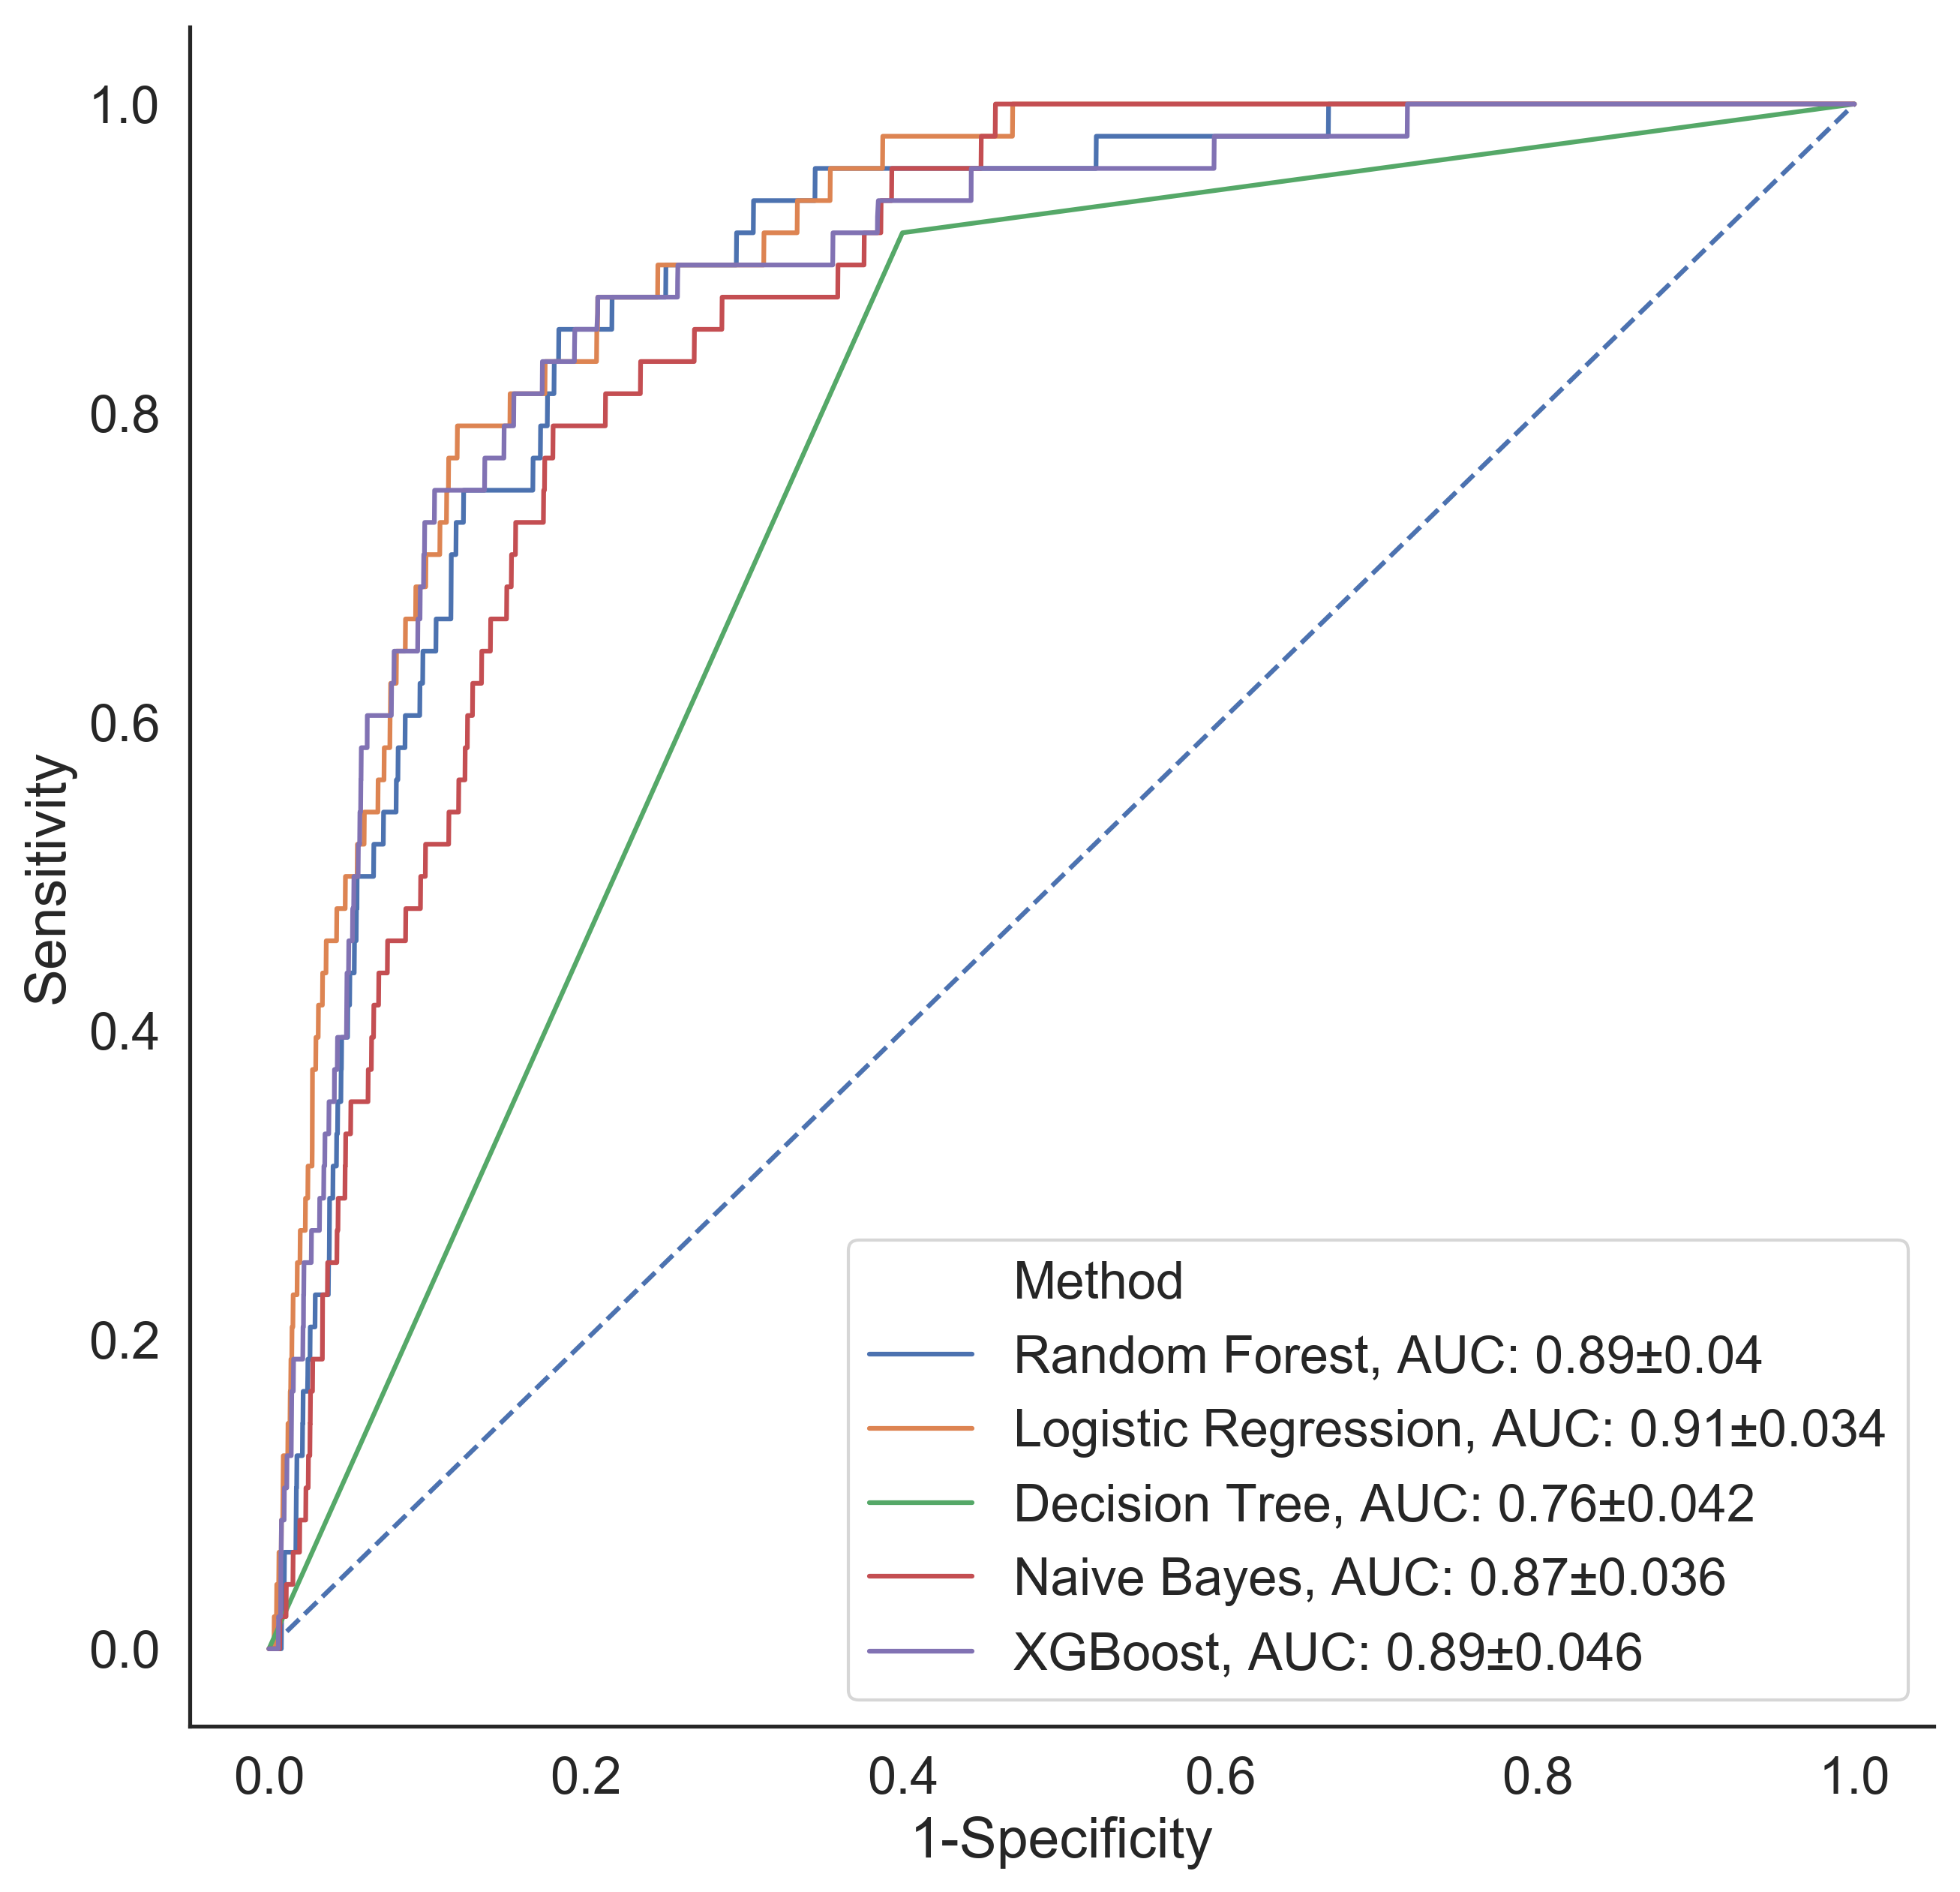

In [46]:
import matplotlib
matplotlib.rcParams['figure.dpi']=400
sns.set(style='white', font_scale=1.5)
np.random.seed(123)

roc_dict={'Random Forest, AUC: {}'.format(return_bootstrap_results(results_rf,auc,1)):roc_df_rf,
          'Logistic Regression, AUC: {}'.format(return_bootstrap_results(results_lr,auc,1)):roc_df_lr,
          'Decision Tree, AUC: {}'.format(return_bootstrap_results(results_dt,auc,1)):roc_df_dt,
          'Naive Bayes, AUC: {}'.format(return_bootstrap_results(results_nb,auc,1)):roc_df_nb,
          'XGBoost, AUC: {}'.format(return_bootstrap_results(results_xg,auc,1)):roc_df_xg}# 
plot_rocs(roc_dict)
sns.despine()

## SHAP Summary and Force Plots  
- Logistic Regression   
- Random Forest  
- XGBoost  

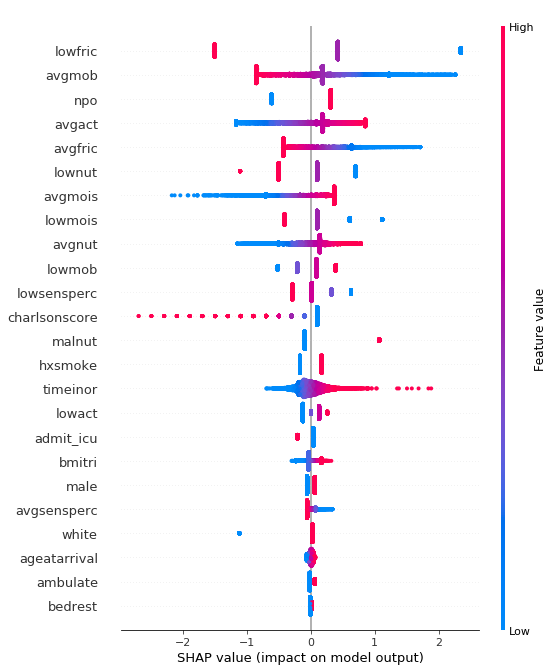

In [19]:
explainer_lr,shap_values_lr=run_shap(X_train, X_test, best_estimator_lr, model_type='linear', explainer_options={}, get_shap_values_options={})
shap_importances=dict(lr=pd.DataFrame(np.abs(shap_values_lr).mean(0),index=list(X_train)).sort_values([0],ascending=False))

Passing 45781 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


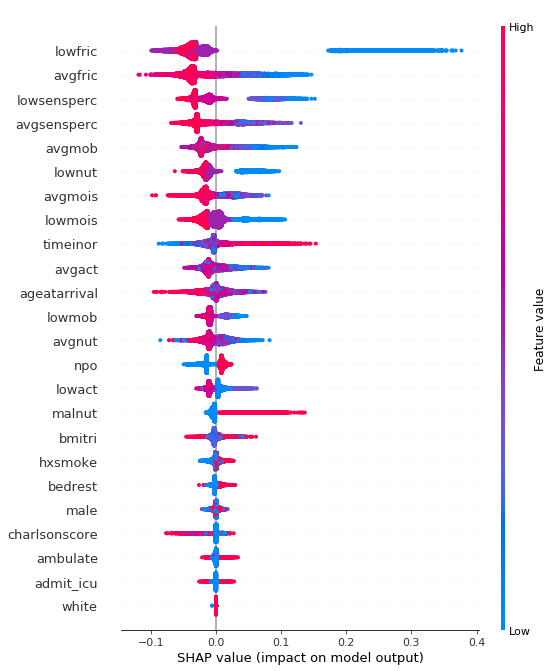

In [33]:
explainer_rf,shap_values_rf=run_shap(X_train, X_test, best_estimator_rf, model_type='tree', explainer_options={}, get_shap_values_options=dict(approximate=True))
shap_importances.update(dict(rf=pd.DataFrame(np.abs(shap_values_rf).mean(0),index=list(X_train)).sort_values([0],ascending=False)))


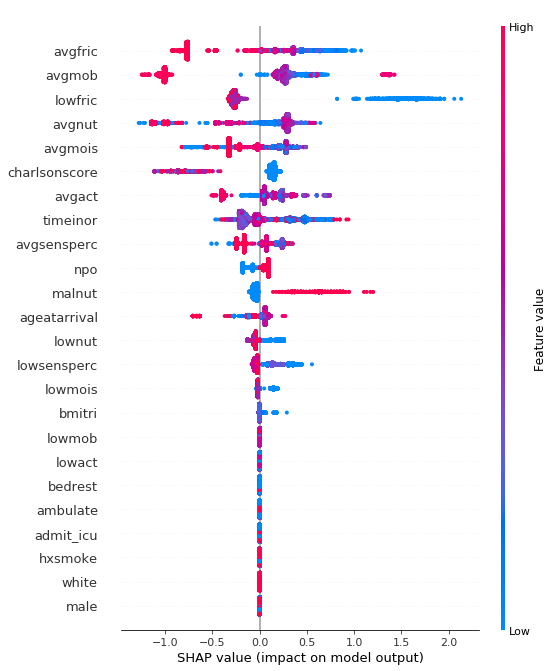

In [30]:
explainer_xg,shap_values_xg=run_shap(X_train, X_test, best_estimator_xg, model_type='tree', explainer_options={}, get_shap_values_options={})
shap_importances.update(dict(xg=pd.DataFrame(np.abs(shap_values_xg).mean(0),index=list(X_train)).sort_values([0],ascending=False)))


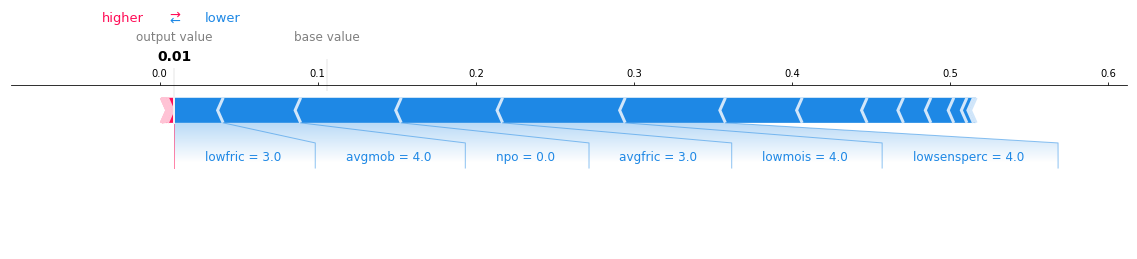

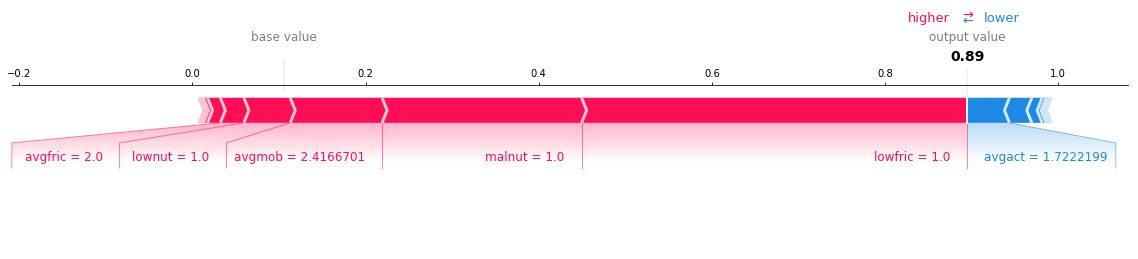

In [21]:
i=7
shap_patient(i, explainer_lr, shap_values_lr, logistic=True)
i=300
shap_patient(i, explainer_lr, shap_values_lr, logistic=True)

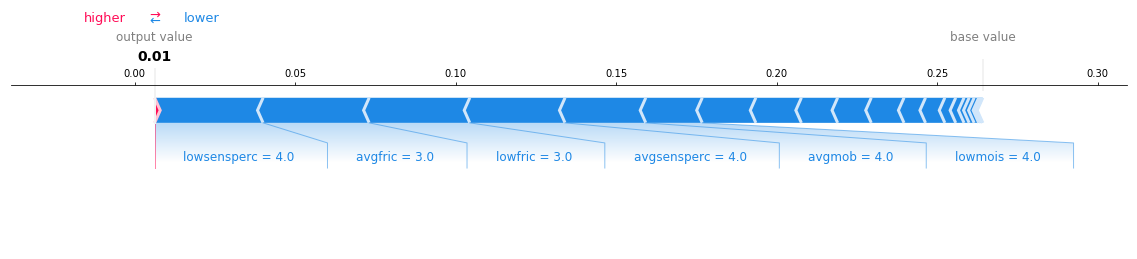

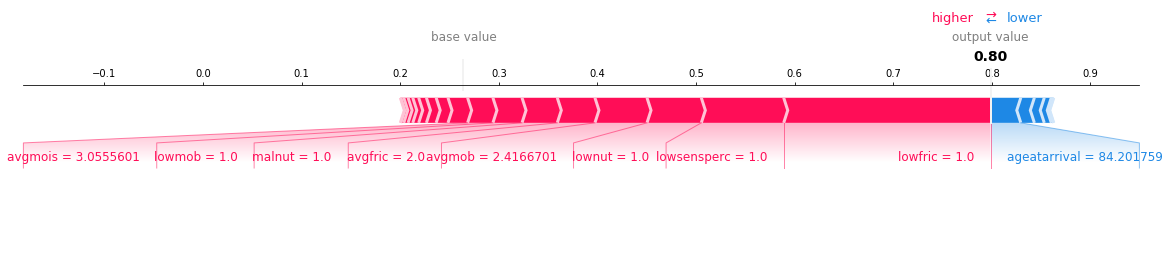

In [38]:
i=7
shap_patient(i, explainer_rf, shap_values_rf, logistic=False,tree=True)
i=300
shap_patient(i, explainer_rf, shap_values_rf, logistic=False,tree=True)

In [ ]:
i=7
shap_patient(i, explainer_xg, shap_values_xg, logistic=False,tree=False)
i=300
shap_patient(i, explainer_xg, shap_values_xg, logistic=False,tree=False)

## SHAP Force Plots Across Cohort
- Logistic Regression  
- Random Forest  
- XGBoost  

In [ ]:
shap.initjs()
shap.force_plot(explainer_lr.expected_value, shap_values_lr[:300],link='logit')

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[:300])

In [ ]:
shap.initjs()
shap.force_plot(explainer_xg.expected_value, shap_values_xg[:300])

## Compare LR, RF, XGBoost SHAP Importances

In [32]:
for k in shap_importances:
    shap_importances[k]=shap_importances[k].loc[list(X_train)]

In [33]:
from scipy.stats import spearmanr
df_rank=pd.DataFrame(columns=list(shap_importances.keys()),index=list(shap_importances.keys()))
for k in shap_importances:
    for k2 in shap_importances:
        df_rank.loc[k,k2]=','.join([str(round(x,4)) for x in spearmanr(shap_importances[k], shap_importances[k2])])

In [34]:
# rank ordered
df_importance=pd.concat(shap_importances.values(),axis=1)
df_importance.columns=['lr','rf','xg']
df_importance=df_importance.iloc[np.argsort(-df_importance['lr'])].apply(lambda x: np.argsort(-x),axis=0)
df_importance+1

,lr,rf,xg
lowfric,1,1,5
avgmob,2,5,2
lownut,3,11,1
npo,4,3,8
avgfric,5,19,6
avgmois,6,6,12
avgact,7,16,7
avgnut,8,2,16
lowmois,9,9,19
lowmob,10,4,4


In [35]:
# raw values
df_importance=pd.concat(shap_importances.values(),axis=1)
df_importance.columns=['lr','rf','xg']
df_importance=df_importance.iloc[np.argsort(-df_importance['lr'])]
df_importance

,lr,rf,xg
lowfric,1.077155,0.063974,0.445495
avgmob,0.444859,0.014991,0.496902
lownut,0.426227,0.026242,0.081018
npo,0.399199,0.012205,0.091580
avgfric,0.372795,0.039484,0.498970
avgmois,0.338860,0.023171,0.237259
avgact,0.322387,0.010141,0.195262
avgnut,0.288830,0.009063,0.380236
lowmois,0.251743,0.012955,0.031901
lowmob,0.224512,0.007830,0.000000


## Compare Logistic Regression SHAP with Normalized Regression Coefficients

In [350]:
import statsmodels.api as sm
import numpy as np
import statsmodels
from sklearn.preprocessing import StandardScaler
np.random.seed(42)

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible"""
    def __init__(self, model_class, fit_intercept=True, kwargs=dict()):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.kwargs=kwargs
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X, **self.kwargs)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)
LogReg=SMWrapper(sm.GLM,kwargs=dict(family=sm.families.Binomial()))
LogReg.fit(X_train,y_train)

X_train2 = sm.add_constant(StandardScaler().fit_transform(X_train))
y_train2 = y_train
LogReg.fit(X_train2,y_train2)
res=pd.read_html(LogReg.results_.summary().tables[1].as_html(),header=0, index_col=0)[0]
res.index=['const']+list(X_train)

Text(0, 0.5, '|Standardized Regression Model Coefficients|')

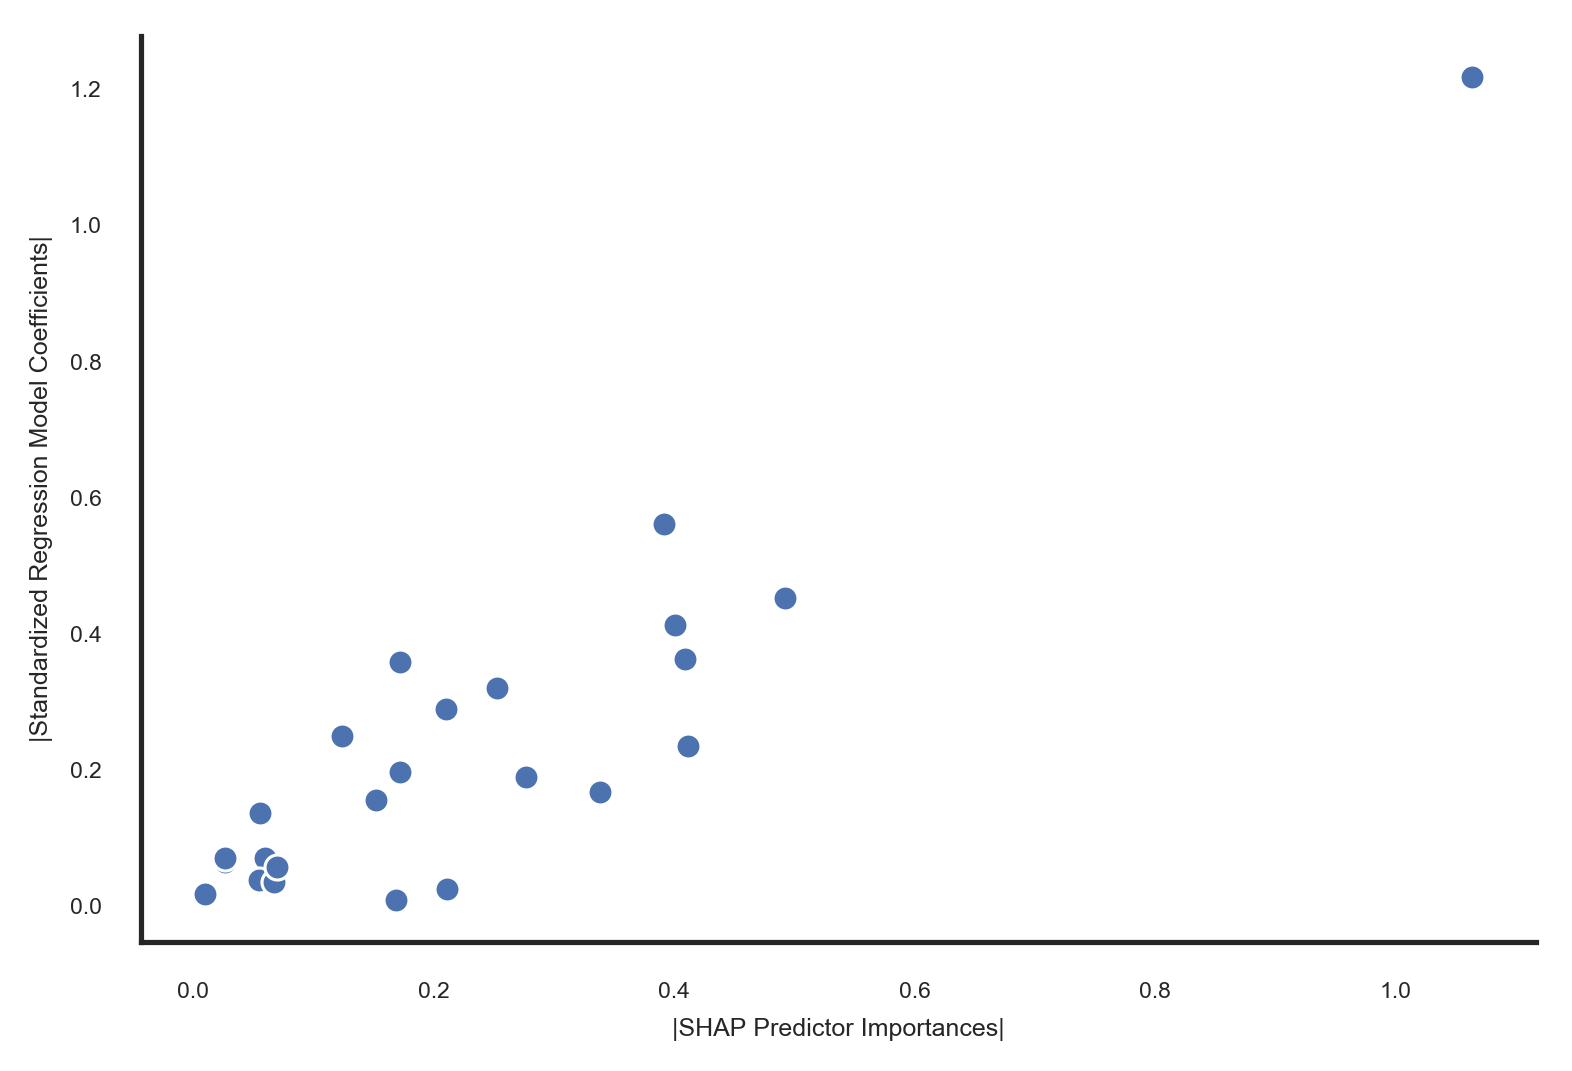

In [353]:
sns.set(font_scale=0.5,style='white')
sns.scatterplot(np.abs(shap_values_lr).mean(0),res['coef'].iloc[1:].abs())
sns.despine()
plt.xlabel('|SHAP Predictor Importances|')
plt.ylabel('|Standardized Regression Model Coefficients|')

In [336]:
from scipy.stats import pearsonr
pearsonr(np.abs(shap_values_lr).mean(0),res['coef'].iloc[1:].abs())

(0.9137826728973484, 4.5060919640262534e-10)